In [12]:
from google.colab import files
uploaded = files.upload()

Saving MSN.csv to MSN.csv


In [13]:
#1. Import library
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM

In [14]:
# 2. Read file MSN
df = pd.read_csv('MSN.csv')
df["Price"] = df["Price"].str.replace(',', '').astype(float)
df1=df.reset_index()['Price']

In [15]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

<h1># 4. Split the data into training, testing, and validation arcording to 7:2:1

In [16]:

train_size = int(0.7 * len(df1))
test_size = int(0.2 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

In [17]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [18]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_val, yval = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [19]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)

In [20]:
# 8. Define LSTM Model

model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [21]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
13/13 [==============================] - 10s 278ms/step - loss: 0.0945 - val_loss: 0.0041
Epoch 2/100
13/13 [==============================] - 2s 179ms/step - loss: 0.0136 - val_loss: 0.0133
Epoch 3/100
13/13 [==============================] - 2s 174ms/step - loss: 0.0076 - val_loss: 0.0016
Epoch 4/100
13/13 [==============================] - 3s 216ms/step - loss: 0.0047 - val_loss: 0.0016
Epoch 5/100
13/13 [==============================] - 4s 268ms/step - loss: 0.0041 - val_loss: 0.0019
Epoch 6/100
13/13 [==============================] - 2s 174ms/step - loss: 0.0037 - val_loss: 0.0020
Epoch 7/100
13/13 [==============================] - 2s 175ms/step - loss: 0.0036 - val_loss: 0.0024
Epoch 8/100
13/13 [==============================] - 2s 176ms/step - loss: 0.0037 - val_loss: 0.0021
Epoch 9/100
13/13 [==============================] - 2s 180ms/step - loss: 0.0035 - val_loss: 0.0015
Epoch 10/100
13/13 [==============================] - 3s 274ms/step - loss: 0.0034 - val_l

In [22]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)
y_pred_val=model.predict(X_val)

1/1 [==============================] - 0s 94ms/step


In [23]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val, yval, ytest
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)
y_pred_val=scaler.inverse_transform(y_pred_val)
ytest = scaler.inverse_transform(ytest.reshape(-1,1))
yval = scaler.inverse_transform(yval.reshape(-1,1))

In [24]:
from sklearn.metrics import mean_absolute_error
# 12. Đánh giá độ chính xác thuật toán bằng RMSE , MAE, MAPE
valid_rmse = np.sqrt(np.mean((y_pred_val - yval)**2))
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))


mae_test = mean_absolute_error(ytest, y_pred)
mae_val = mean_absolute_error(yval, y_pred_val)

mape_test = np.mean(np.abs((ytest - y_pred) / ytest)) * 100
mape_val = np.mean(np.abs((yval - y_pred_val) / yval)) * 100

print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)
print("Validate MAE: ", mae_val)
print("Test MAE: ", mae_test)
print("Validate MAPE: ", mape_val)
print("Test MAPE: ", mape_test)

Validation RMSE: 2096.4415257360065
Testing RMSE: 2300.417712297083
Validate MAE:  1725.3399697580649
Test MAE:  1747.180073302469
Validate MAPE:  2.4294021213590082
Test MAPE:  2.3847837166248413


In [25]:
# 13. Dự báo 90 ngày tiếp theo
x_input=val_data[32:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=100
i=0
while(i<90):

    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1

[0.36893845]
101
1 day input [0.27278593 0.26007684 0.25518873 0.25616635 0.25518873 0.24247964
 0.25030062 0.26496495 0.25714397 0.2581216  0.27180831 0.27083069
 0.26887544 0.25616635 0.26203209 0.25225586 0.25030062 0.25518873
 0.23856915 0.24541251 0.24834537 0.24345726 0.24247964 0.24345726
 0.24345726 0.25616635 0.28256215 0.28158453 0.27376355 0.27474117
 0.26105446 0.26105446 0.26985306 0.27669642 0.29722649 0.29820411
 0.30113697 0.34904046 0.36077193 0.3988992  0.37641389 0.36663766
 0.37836913 0.39987682 0.38032438 0.37641389 0.37054815 0.36566004
 0.36468242 0.37152578 0.37641389 0.34708522 0.33242089 0.3461076
 0.35197333 0.33437613 0.32655515 0.337309   0.32655515 0.32655515
 0.31189082 0.31189082 0.32753277 0.31775655 0.3109132  0.31189082
 0.26300971 0.25518873 0.26203209 0.25909922 0.26300971 0.24150202
 0.26300971 0.27474117 0.26594257 0.27376355 0.29136075 0.30406984
 0.30504746 0.31580131 0.30700271 0.30113697 0.30113697 0.29918173
 0.31482369 0.31677893 0.34708522 

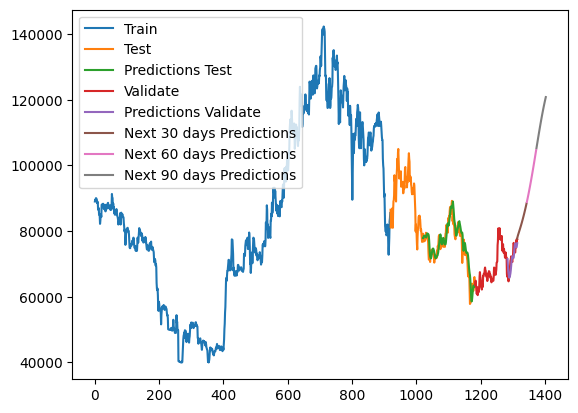

In [26]:
# 14.Vẽ hình

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))

test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))

test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))

val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))

val_data_index = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)

next_30_days_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(next_30_days_index, scaler.inverse_transform(lst_output[:30]))

next_60_days_index = pd.RangeIndex(start=len(df1)+29, stop=len(df1)+59, step=1)
plt.plot(next_60_days_index, scaler.inverse_transform(lst_output[30:60]))

next_90_days_index = pd.RangeIndex(start=len(df1)+59, stop=len(df1)+89, step=1)
plt.plot(next_90_days_index, scaler.inverse_transform(lst_output[60:]))

plt.legend(['Train','Test','Predictions Test','Validate','Predictions Validate','Next 30 days Predictions','Next 60 days Predictions','Next 90 days Predictions'])

plt.show()

<h1># 4. Split the data into training, testing, and validation arcording to 5:3:2

In [27]:
train_size = int(0.5 * len(df1))
test_size = int(0.3 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

In [28]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [29]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_val, yval = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [30]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)

In [31]:
# 8. Define LSTM Model

model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [32]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
9/9 [==============================] - 10s 403ms/step - loss: 0.0399 - val_loss: 0.0067
Epoch 2/100
9/9 [==============================] - 3s 298ms/step - loss: 0.0103 - val_loss: 0.0063
Epoch 3/100
9/9 [==============================] - 2s 278ms/step - loss: 0.0054 - val_loss: 0.0053
Epoch 4/100
9/9 [==============================] - 2s 196ms/step - loss: 0.0034 - val_loss: 0.0150
Epoch 5/100
9/9 [==============================] - 2s 195ms/step - loss: 0.0029 - val_loss: 0.0059
Epoch 6/100
9/9 [==============================] - 2s 195ms/step - loss: 0.0026 - val_loss: 0.0096
Epoch 7/100
9/9 [==============================] - 2s 195ms/step - loss: 0.0024 - val_loss: 0.0074
Epoch 8/100
9/9 [==============================] - 2s 194ms/step - loss: 0.0023 - val_loss: 0.0079
Epoch 9/100
9/9 [==============================] - 2s 267ms/step - loss: 0.0023 - val_loss: 0.0071
Epoch 10/100
9/9 [==============================] - 3s 285ms/step - loss: 0.0022 - val_loss: 0.0076
Epoch 11

In [33]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)
y_pred_val=model.predict(X_val)

6/6 [==============================] - 0s 33ms/step


In [34]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val, yval, ytest
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)
y_pred_val=scaler.inverse_transform(y_pred_val)
ytest = scaler.inverse_transform(ytest.reshape(-1,1))
yval = scaler.inverse_transform(yval.reshape(-1,1))

In [35]:
from sklearn.metrics import mean_absolute_error
# 12. Đánh giá độ chính xác thuật toán bằng RMSE , MAE, MAPE
valid_rmse = np.sqrt(np.mean((y_pred_val - yval)**2))
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))


mae_test = mean_absolute_error(ytest, y_pred)
mae_val = mean_absolute_error(yval, y_pred_val)

mape_test = np.mean(np.abs((ytest - y_pred) / ytest)) * 100
mape_val = np.mean(np.abs((yval - y_pred_val) / yval)) * 100

print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)
print("Validate MAE: ", mae_val)
print("Test MAE: ", mae_test)
print("Validate MAPE: ", mape_val)
print("Test MAPE: ", mape_test)

Validation RMSE: 2176.9355934863393
Testing RMSE: 3204.4573787469844
Validate MAE:  1658.4760832055215
Test MAE:  2456.700938566553
Validate MAPE:  2.415222437829305
Test MAPE:  2.5181776520438466


In [36]:
# 13. Dự báo 90 ngày tiếp theo
x_input=val_data[164:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=100
i=0
while(i<90):

    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1


[0.358548]
101
1 day input [0.27278593 0.26007684 0.25518873 0.25616635 0.25518873 0.24247964
 0.25030062 0.26496495 0.25714397 0.2581216  0.27180831 0.27083069
 0.26887544 0.25616635 0.26203209 0.25225586 0.25030062 0.25518873
 0.23856915 0.24541251 0.24834537 0.24345726 0.24247964 0.24345726
 0.24345726 0.25616635 0.28256215 0.28158453 0.27376355 0.27474117
 0.26105446 0.26105446 0.26985306 0.27669642 0.29722649 0.29820411
 0.30113697 0.34904046 0.36077193 0.3988992  0.37641389 0.36663766
 0.37836913 0.39987682 0.38032438 0.37641389 0.37054815 0.36566004
 0.36468242 0.37152578 0.37641389 0.34708522 0.33242089 0.3461076
 0.35197333 0.33437613 0.32655515 0.337309   0.32655515 0.32655515
 0.31189082 0.31189082 0.32753277 0.31775655 0.3109132  0.31189082
 0.26300971 0.25518873 0.26203209 0.25909922 0.26300971 0.24150202
 0.26300971 0.27474117 0.26594257 0.27376355 0.29136075 0.30406984
 0.30504746 0.31580131 0.30700271 0.30113697 0.30113697 0.29918173
 0.31482369 0.31677893 0.34708522 0.

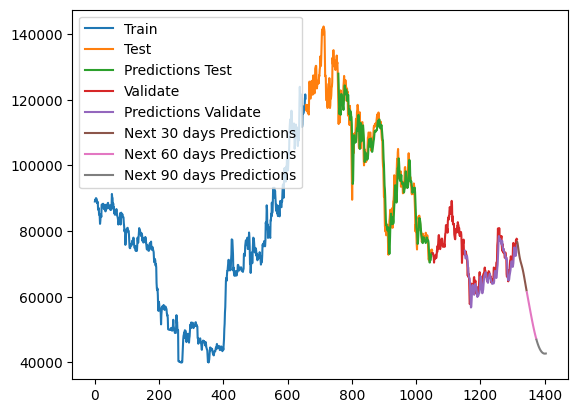

In [37]:
# 14.Vẽ hình

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))

test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))

test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))

val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))

val_data_index = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)

next_30_days_index = pd.RangeIndex(start=len(df1), stop=len(df1)+30, step=1)
plt.plot(next_30_days_index, scaler.inverse_transform(lst_output[:30]))

next_60_days_index = pd.RangeIndex(start=len(df1)+30, stop=len(df1)+60, step=1)
plt.plot(next_60_days_index, scaler.inverse_transform(lst_output[30:60]))

next_90_days_index = pd.RangeIndex(start=len(df1)+60, stop=len(df1)+90, step=1)
plt.plot(next_90_days_index, scaler.inverse_transform(lst_output[60:]))

plt.legend(['Train','Test','Predictions Test','Validate','Predictions Validate','Next 30 days Predictions','Next 60 days Predictions','Next 90 days Predictions'])

plt.show()


<h1># 4. Split the data into training, testing, and validation arcording to 6:3:1

In [38]:

train_size = int(0.6 * len(df1))
test_size = int(0.3 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

In [39]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [40]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_val, yval = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [41]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)

In [42]:
# 8. Define LSTM Model

model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [43]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
11/11 [==============================] - 9s 323ms/step - loss: 0.0912 - val_loss: 0.0182
Epoch 2/100
11/11 [==============================] - 3s 281ms/step - loss: 0.0136 - val_loss: 0.0092
Epoch 3/100
11/11 [==============================] - 3s 254ms/step - loss: 0.0057 - val_loss: 0.0048
Epoch 4/100
11/11 [==============================] - 2s 195ms/step - loss: 0.0043 - val_loss: 0.0088
Epoch 5/100
11/11 [==============================] - 2s 190ms/step - loss: 0.0035 - val_loss: 0.0077
Epoch 6/100
11/11 [==============================] - 2s 192ms/step - loss: 0.0032 - val_loss: 0.0057
Epoch 7/100
11/11 [==============================] - 2s 193ms/step - loss: 0.0032 - val_loss: 0.0058
Epoch 8/100
11/11 [==============================] - 3s 288ms/step - loss: 0.0030 - val_loss: 0.0062
Epoch 9/100
11/11 [==============================] - 3s 244ms/step - loss: 0.0030 - val_loss: 0.0059
Epoch 10/100
11/11 [==============================] - 2s 195ms/step - loss: 0.0030 - val_lo

In [44]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)
y_pred_val=model.predict(X_val)

1/1 [==============================] - 0s 203ms/step


In [45]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val, yval, ytest
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)
y_pred_val=scaler.inverse_transform(y_pred_val)
ytest = scaler.inverse_transform(ytest.reshape(-1,1))
yval = scaler.inverse_transform(yval.reshape(-1,1))

In [46]:
from sklearn.metrics import mean_absolute_error
# 12. Đánh giá độ chính xác thuật toán bằng RMSE , MAE, MAPE
valid_rmse = np.sqrt(np.mean((y_pred_val - yval)**2))
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))


mae_test = mean_absolute_error(ytest, y_pred)
mae_val = mean_absolute_error(yval, y_pred_val)

mape_test = np.mean(np.abs((ytest - y_pred) / ytest)) * 100
mape_val = np.mean(np.abs((yval - y_pred_val) / yval)) * 100

print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)
print("Validate MAE: ", mae_val)
print("Test MAE: ", mae_test)
print("Validate MAPE: ", mape_val)
print("Test MAPE: ", mape_test)

Validation RMSE: 3268.1337593601565
Testing RMSE: 3581.130832691914
Validate MAE:  2801.704637096774
Test MAE:  2730.389265145051
Validate MAPE:  3.8774834059611614
Test MAPE:  3.318842549676172


In [47]:
# 13. Dự báo 90 ngày tiếp theo
x_input=val_data[32:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=100
i=0
while(i<90):

    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1


[0.34181222]
101
1 day input [0.27278593 0.26007684 0.25518873 0.25616635 0.25518873 0.24247964
 0.25030062 0.26496495 0.25714397 0.2581216  0.27180831 0.27083069
 0.26887544 0.25616635 0.26203209 0.25225586 0.25030062 0.25518873
 0.23856915 0.24541251 0.24834537 0.24345726 0.24247964 0.24345726
 0.24345726 0.25616635 0.28256215 0.28158453 0.27376355 0.27474117
 0.26105446 0.26105446 0.26985306 0.27669642 0.29722649 0.29820411
 0.30113697 0.34904046 0.36077193 0.3988992  0.37641389 0.36663766
 0.37836913 0.39987682 0.38032438 0.37641389 0.37054815 0.36566004
 0.36468242 0.37152578 0.37641389 0.34708522 0.33242089 0.3461076
 0.35197333 0.33437613 0.32655515 0.337309   0.32655515 0.32655515
 0.31189082 0.31189082 0.32753277 0.31775655 0.3109132  0.31189082
 0.26300971 0.25518873 0.26203209 0.25909922 0.26300971 0.24150202
 0.26300971 0.27474117 0.26594257 0.27376355 0.29136075 0.30406984
 0.30504746 0.31580131 0.30700271 0.30113697 0.30113697 0.29918173
 0.31482369 0.31677893 0.34708522 

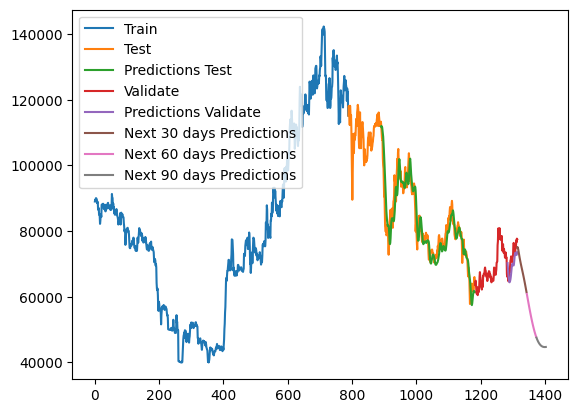

In [48]:
# 14.Vẽ hình

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))

test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))

test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))

val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))

val_data_index = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)

next_30_days_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(next_30_days_index, scaler.inverse_transform(lst_output[:30]))

next_60_days_index = pd.RangeIndex(start=len(df1)+29, stop=len(df1)+59, step=1)
plt.plot(next_60_days_index, scaler.inverse_transform(lst_output[30:60]))

next_90_days_index = pd.RangeIndex(start=len(df1)+59, stop=len(df1)+89, step=1)
plt.plot(next_90_days_index, scaler.inverse_transform(lst_output[60:]))

plt.legend(['Train','Test','Predictions Test','Validate','Predictions Validate','Next 30 days Predictions','Next 60 days Predictions','Next 90 days Predictions'])

plt.show()